# Generate Synthetic Data

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

module_name = "spiker_seg_narrow_range"

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

sim_par= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/model/spiker_seg_narrow_range/synthetic_0.1_0.2_0.3_


(5000,)


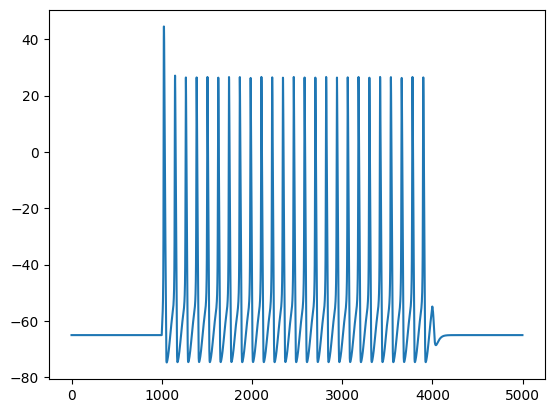

In [2]:
import numpy as np
dataset = np.load(f"./model/{module_name}/synthetic_0.1_0.2_0.3_/combined_out.npy")

V = dataset[0,:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

In [3]:
passive_sim_par = SimParams(
            h_v_init = -65,
            h_tstop = 500,
            h_dt = 0.1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 300,
            CI_delay = 100,
            set_g_to=[]
        )

sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= passive_sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg_narrow_range/synthetic_-0.1_


(5000,)


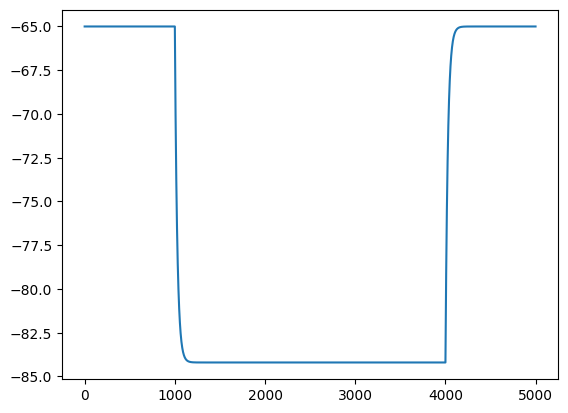

In [4]:
import numpy as np
dataset = np.loadtxt('./model/spiker_segregated/target/passive_data.csv', delimiter=',', skiprows=1)

V = dataset[:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

# Get Passive Properties

In [5]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=passive_sim_par,
    trace_filepath=f"./model/{module_name}/target/passive_data.csv",
    leak_conductance_variable="gl_hh_seg",
    leak_reversal_variable="el_hh_seg"
)

In [6]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-65.0, R_in=191.99802919980584, tau=2.7, Cm=1.2664890000000124, g_bar_leak=0.00046907000000000453, cell_area=1.1103645074847766e-05, leak_conductance_variable='gl_hh_seg', leak_reversal_variable='el_hh_seg')


# Run Original Pipeline with Passive Prediction

In [7]:
from act.ACTModule import ACTModule
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import  Cell, SimParams, OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_name,
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", low=0.1, high=0.15, n_slices=10),
                OptimizationParam(param="gkbar_hh_seg", low=0.0, high=0.05, n_slices=10),
                OptimizationParam(param="gl_hh_seg", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1),
                
            ],
            prediction_eval_method='fi_curve'
        )
    )
)

In [8]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 300
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg_narrow_range/train
TRAINING RANDOM FOREST REGRESSOR
-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 300/300 [02:32<00:00,  1.97it/s]


Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
Evaluating random forest
MAE: 0.002240 (0.000248)
Predicted Conductances for each current injection intensity: 
[[0.13180556 0.04236111 0.00046907]
 [0.12643889 0.04001667 0.00046907]
 [0.12292222 0.03516667 0.00046907]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg_narrow_range/prediction_eval0
/home/mwsrgf/proj/ACT/model/spiker_seg_narrow_range/prediction_eval1
/home/mwsrgf/proj/ACT/model/spiker_seg_narrow_range/prediction_eval2
SELECTING BEST PREDICTION
FI curve MAE for each prediction: 
[3.3333333333333335, 2.2222222222222237, 1.1111111111111096]
{'gnabar_hh_seg': 0.12292222222222124, 'gkbar_hh_seg': 0.03516666666666704, 'gl

In [9]:
mod.pickle_rf(mod.rf_model,f"./model/{module_name}/trained_rf.pkl")

In [11]:
from act import ACTPlot
ACTPlot.plot_v_comparison(predicted_g_data_file, f"./model/{module_name}/target", f"./model/{module_name}", [0.1,0.2,0.3])
ACTPlot.plot_fi_comparison(f"./model/{module_name}/results/frequency_data_2.npy", [0.1,0.2,0.3])

# Closer Look

0.0
[0.12643889 0.04001667 0.00046907]


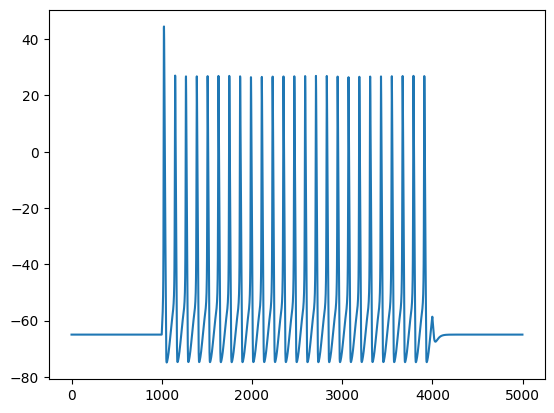

In [12]:
import numpy as np
evaluation_num = 1
dataset = np.load(f"./model/{module_name}/prediction_eval{evaluation_num}/combined_out.npy")
sample = 0
V = dataset[sample,:,0]
I = dataset[sample,150,1]
g = dataset[sample,:3,2]
print(I)
print(f"{g}")

from matplotlib import pyplot as plt

plt.plot(V)

(5000,)
[0.12       0.036      0.00046907]


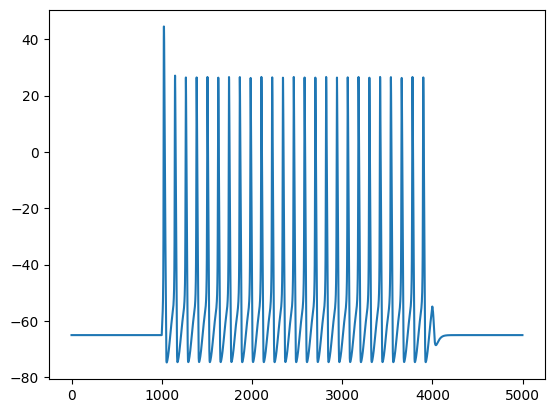

In [13]:
import numpy as np
dataset = np.load(f"./model/{module_name}/synthetic_0.1_0.2_0.3_/combined_out.npy")

sample = 0
V = dataset[sample,:,0]
g = dataset[sample,:3,2]
print(V.shape)
print(g)

from matplotlib import pyplot as plt

plt.plot(V)

In [14]:
from act.DataProcessor import DataProcessor
import numpy as np

dp = DataProcessor()

# Get Target Cell Frequencies
dataset = np.load(f"./model/{module_name}/target/combined_out.npy")

V_target = dataset[:,:,0]

target_frequencies = dp.get_fi_curve(V_target, [0.1,0.2,0.3], inj_dur=300).flatten()
print(target_frequencies)

[ 83.33333333  96.66666667 103.33333333]


/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Ordered [  2  13 289] to [289   2  13]
Ordered [  3   4 299] to [299   3   4]


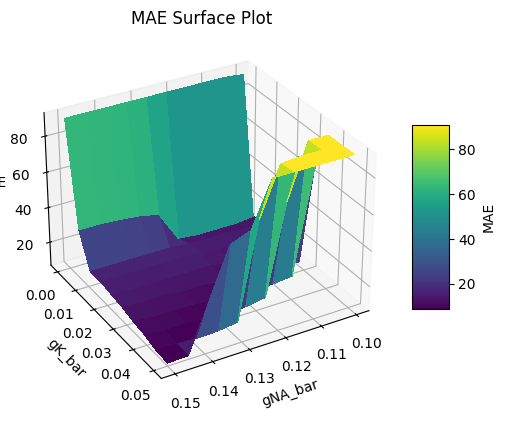

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from act.DataProcessor import DataProcessor
from act.Metrics import Metrics
from matplotlib import cm

from act import ACTPlot as actplt

module_name = "spiker_seg_narrow_range"

actplt.plot_training_fi_mae_surface_spiker_cell(
f"./model/{module_name}/target/combined_out.npy",
f"./model/{module_name}/train/combined_out.npy",
[0.1,0.2,0.3],
300,
100,
0.1,
f"./model/{module_name}/results/FI_MAE_Surface.html",
)

found indices: 6000
found indices: 6000
found indices: 6000


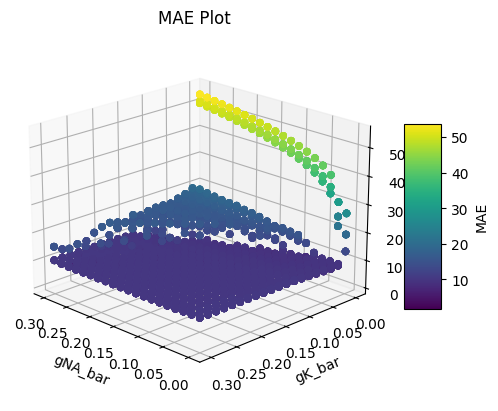

In [ ]:
from act import ACTPlot as actplt

actplt.plot_training_v_mae_scatter_spiker_cell(
    f"./model/{module_name}/target/combined_out.npy",
    f"./model/{module_name}/train/combined_out.npy",
    100,
    0.1
)
